<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone Project: COVID-19 mRNA Vaccine Degradation Prediction

# Part 2

In [1]:
import warnings
warnings.filterwarnings('ignore')

#the basics
import pandas as pd, numpy as np
import math, json, gc, random, os, sys
import seaborn as sns
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.inspection import permutation_importance

## Loading Train Dataset

In [2]:
train = pd.read_json('./stanford-covid-vaccine/train.json', lines=True)
train.drop(['index'], axis=1, inplace=True)
train.head()

,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


### Outlier Removal

In [3]:
train = train.query("signal_to_noise >= 1")
train.shape
# Original train shape is (2400, 18)

(2097, 18)

## Loading Test Dataset

In [4]:
test = pd.read_json('./stanford-covid-vaccine/test.json', lines=True)
test.drop(['index'], axis=1, inplace=True)
test.head()

,id,sequence,structure,predicted_loop_type,seq_length,seq_scored
0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68
3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68
4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91


## Model Preprocessing - Flattening

In [5]:
train_data = []
for mol_id in train['id'].unique():
    sample_data = train.loc[train['id'] == mol_id]
    for i in range(68):
        sample_tuple = (sample_data['id'].values[0], sample_data['sequence'].values[0][i],
                        sample_data['structure'].values[0][i], sample_data['predicted_loop_type'].values[0][i],
                        sample_data['reactivity'].values[0][i], sample_data['reactivity_error'].values[0][i],
                        sample_data['deg_Mg_pH10'].values[0][i], sample_data['deg_error_Mg_pH10'].values[0][i],
                        sample_data['deg_pH10'].values[0][i], sample_data['deg_error_pH10'].values[0][i],
                        sample_data['deg_Mg_50C'].values[0][i], sample_data['deg_error_Mg_50C'].values[0][i],
                        sample_data['deg_50C'].values[0][i], sample_data['deg_error_50C'].values[0][i])
        train_data.append(sample_tuple)

In [6]:
train_data = pd.DataFrame(train_data, columns=['id', 'sequence', 'structure', 'predicted_loop_type', 
                                               'reactivity', 'reactivity_error', 'deg_Mg_pH10', 'deg_error_Mg_pH10',
                                               'deg_pH10', 'deg_error_pH10', 'deg_Mg_50C', 'deg_error_Mg_50C', 'deg_50C', 'deg_error_50C'])
train_data.head()

,id,sequence,structure,predicted_loop_type,reactivity,reactivity_error,deg_Mg_pH10,deg_error_Mg_pH10,deg_pH10,deg_error_pH10,deg_Mg_50C,deg_error_Mg_50C,deg_50C,deg_error_50C
0,id_001f94081,G,.,E,0.3297,0.1359,0.7556,0.2613,2.3375,0.2631,0.3581,0.1501,0.6382,0.2167
1,id_001f94081,G,.,E,1.5693,0.2070,2.9830,0.3842,3.5060,0.2860,2.9683,0.2750,3.4773,0.3475
2,id_001f94081,A,.,E,1.1227,0.1633,0.2526,0.1372,0.3008,0.0964,0.2589,0.0947,0.9988,0.1880
3,id_001f94081,A,.,E,0.8686,0.1452,1.3789,0.2531,1.0108,0.1574,1.4552,0.1866,1.3228,0.2124
4,id_001f94081,A,.,E,0.7217,0.1314,0.6376,0.1798,0.2635,0.1000,0.7244,0.1369,0.7877,0.1703


In [7]:
train_copy = pd.DataFrame(train, columns=['id', 'signal_to_noise', 'SN_filter', 'seq_length', 'seq_scored'])

In [8]:
train_copy.head()

,id,signal_to_noise,SN_filter,seq_length,seq_scored
0,id_001f94081,6.894,1,107,68
2,id_006f36f57,8.800,1,107,68
5,id_00ab2d761,4.136,1,107,68
6,id_00abef1d7,2.485,1,107,68
7,id_00b436dec,1.727,1,107,68


In [9]:
train_rg = pd.merge(train_data, train_copy, on=['id'])

In [10]:
#Mapping string values to numerical values
train_rg['sequence'] = train_rg['sequence'].map({'A': 0, 'G' : 1, 'C' : 2, 'U' : 3})
train_rg['structure'] = train_rg['structure'].map({'.' : 0, '(' : 1, ')' : 2})
train_rg['predicted_loop_type'] = train_rg['predicted_loop_type'].map({'S':0, 'E':1, 'H':2, 'I':3, 'X':4, 'M':5, 'B':6})

In [11]:
train_rg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142596 entries, 0 to 142595
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   142596 non-null  object 
 1   sequence             142596 non-null  int64  
 2   structure            142596 non-null  int64  
 3   predicted_loop_type  142596 non-null  int64  
 4   reactivity           142596 non-null  float64
 5   reactivity_error     142596 non-null  float64
 6   deg_Mg_pH10          142596 non-null  float64
 7   deg_error_Mg_pH10    142596 non-null  float64
 8   deg_pH10             142596 non-null  float64
 9   deg_error_pH10       142596 non-null  float64
 10  deg_Mg_50C           142596 non-null  float64
 11  deg_error_Mg_50C     142596 non-null  float64
 12  deg_50C              142596 non-null  float64
 13  deg_error_50C        142596 non-null  float64
 14  signal_to_noise      142596 non-null  float64
 15  SN_filter        

In [12]:
test_data = []
for mol_id in test['id'].unique():
    sample_data = test.loc[test['id'] == mol_id]
    for i in range(sample_data['seq_scored'].values[0]):
        sample_tuple = (sample_data['id'].values[0], sample_data['sequence'].values[0][i],
                        sample_data['structure'].values[0][i], sample_data['predicted_loop_type'].values[0][i])
        test_data.append(sample_tuple)

In [13]:
test_data = pd.DataFrame(test_data, columns=['id', 'sequence', 'structure', 'predicted_loop_type'])
test_data.head()

,id,sequence,structure,predicted_loop_type
0,id_00073f8be,G,.,E
1,id_00073f8be,G,.,E
2,id_00073f8be,A,.,E
3,id_00073f8be,A,.,E
4,id_00073f8be,A,.,E


In [14]:
test_copy = pd.DataFrame(test, columns=['id', 'seq_length', 'seq_scored'])

In [15]:
test_copy.head()

,id,seq_length,seq_scored
0,id_00073f8be,107,68
1,id_000ae4237,130,91
2,id_00131c573,107,68
3,id_00181fd34,107,68
4,id_0020473f7,130,91


In [16]:
test_rg = pd.merge(test_data, test_copy, on=['id'])

In [17]:
#Mapping string values to numerical values
test_rg['sequence'] = test_rg['sequence'].map({'A': 0, 'G' : 1, 'C' : 2, 'U' : 3})
test_rg['structure'] = test_rg['structure'].map({'.' : 0, '(' : 1, ')' : 2})
test_rg['predicted_loop_type'] = test_rg['predicted_loop_type'].map({'S':0, 'E':1, 'H':2, 'I':3, 'X':4, 'M':5, 'B':6})

In [18]:
test_rg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316227 entries, 0 to 316226
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   id                   316227 non-null  object
 1   sequence             316227 non-null  int64 
 2   structure            316227 non-null  int64 
 3   predicted_loop_type  316227 non-null  int64 
 4   seq_length           316227 non-null  int64 
 5   seq_scored           316227 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 16.9+ MB


In [51]:
test_rg.head()

,sequence,structure,predicted_loop_type
id,,,
id_00073f8be,1,0,1
id_00073f8be,1,0,1
id_00073f8be,0,0,1
id_00073f8be,0,0,1
id_00073f8be,0,0,1


## Model Preprocessing -- Train Test Split

In [19]:
train_rg = train_rg.set_index('id')
train_rg.head()

,sequence,structure,predicted_loop_type,reactivity,reactivity_error,deg_Mg_pH10,deg_error_Mg_pH10,deg_pH10,deg_error_pH10,deg_Mg_50C,deg_error_Mg_50C,deg_50C,deg_error_50C,signal_to_noise,SN_filter,seq_length,seq_scored
id,,,,,,,,,,,,,,,,,
id_001f94081,1,0,1,0.3297,0.1359,0.7556,0.2613,2.3375,0.2631,0.3581,0.1501,0.6382,0.2167,6.894,1,107,68
id_001f94081,1,0,1,1.5693,0.2070,2.9830,0.3842,3.5060,0.2860,2.9683,0.2750,3.4773,0.3475,6.894,1,107,68
id_001f94081,0,0,1,1.1227,0.1633,0.2526,0.1372,0.3008,0.0964,0.2589,0.0947,0.9988,0.1880,6.894,1,107,68
id_001f94081,0,0,1,0.8686,0.1452,1.3789,0.2531,1.0108,0.1574,1.4552,0.1866,1.3228,0.2124,6.894,1,107,68
id_001f94081,0,0,1,0.7217,0.1314,0.6376,0.1798,0.2635,0.1000,0.7244,0.1369,0.7877,0.1703,6.894,1,107,68


In [20]:
test_rg = test_rg.set_index('id')
test_rg.head()

,sequence,structure,predicted_loop_type,seq_length,seq_scored
id,,,,,
id_00073f8be,1,0,1,107,68
id_00073f8be,1,0,1,107,68
id_00073f8be,0,0,1,107,68
id_00073f8be,0,0,1,107,68
id_00073f8be,0,0,1,107,68


In [21]:
# Create X and y.
targets = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
X = train_rg[['sequence', 'structure', 'predicted_loop_type']]
y = train_rg[targets]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('X_train shape: {}'.format(X_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_train shape: {}'.format(y_train.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (114076, 3)
X_test shape: (28520, 3)
y_train shape: (114076, 5)
y_test shape: (28520, 5)


In [23]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)# the same as doing ss.fit(X_train), then X_train=ss.transform(X_train)
X_test = ss.transform(X_test)

## Metric - MCRMSE
Mean Columnwise Root Mean Square Error (MCRMSE) is used to validate the model. MCRMSE is the square root of the mean/average of the square of all of the error.

Normally, we can calculate RMSE to get a single-number evaluation metric for our prediction, but if we are predicting multiple values at once−in the case of the OpenVaccine competition, we need to predict degradation rates under multiple conditions−we would get multiple different RMSE values, one for each column.

The MCRMSE is simply an average across all RMSE values for each of our columns, so we can still use a single-number evaluation metric, even in the case of multiple outputs.

In [24]:
def mcrmse_loss(y_true, y_pred, N=3):
    """
    Calculates competition eval metric.
    From: https://www.kaggle.com/kaushal2896/openvaccine-xgboost-baseline
    """
    assert len(y_true) == len(y_pred)
    n = len(y_true)
    return np.sum(np.sqrt(np.sum((y_true - y_pred)**2, axis=0)/n)) / N

## Baseline Modelling -- Dummy regression (Mean)

In [25]:
lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)

In [26]:
y_pred = lm_dummy_mean.predict(X_test)
print('Train Score :',lm_dummy_mean.score(X_train, y_train))
print('Test Score :',lm_dummy_mean.score(X_test, y_test))
print('Train MCRSME:',mcrmse_loss(y_train, lm_dummy_mean.predict(X_train)))
print('Test MCRSME:',mcrmse_loss(y_test, y_pred))

Train Score : 5.10702591327572e-16
Test Score : -2.73376320272245e-05
Train MCRSME: 0.8430065225611267
Test MCRSME: 0.8410704693598562


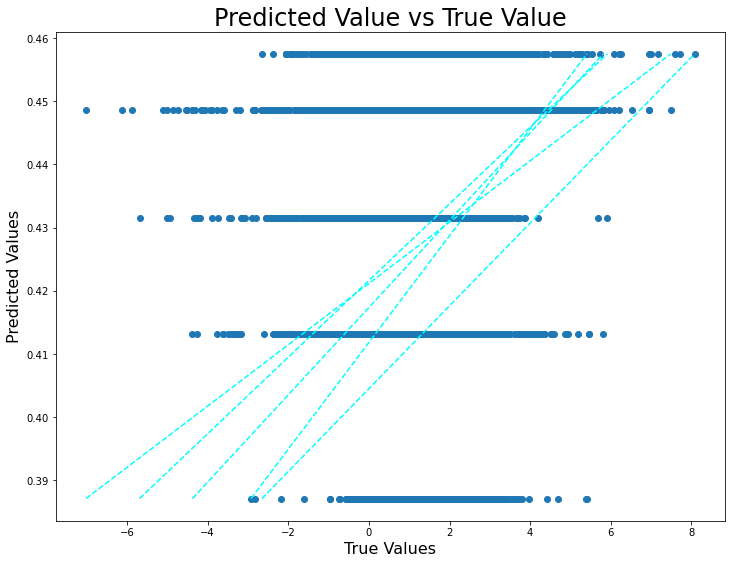

In [27]:
y_pred = lm_dummy_mean.predict(X_test)

plt.figure(figsize = (12, 9))

# Examine the relationship between observed and predicted values.
plt.scatter(y_test, y_pred)

# Line showing perfect predictions.
plt.plot([y_test.min(), y_test.max()],
         [y_pred.min(),y_pred.max()],
         linestyle = '--', color='aqua')

plt.title('Predicted Value vs True Value', fontsize = 24)
plt.xlabel('True Values', fontsize = 16)
plt.ylabel('Predicted Values', fontsize = 16);

## Other Regressor Modelling

In [28]:
# dictionary to hold the metrics for each runs
metrics = {}
# dictionary to hold the models for each runs
models = {}

In [29]:
def model_metrics(tag, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    metric = {}
    metric['01 Train score'] = f'{model.score(X_train, y_train):,.4f}'
    metric['02 Test score'] = f'{model.score(X_test, y_test):,.4f}'
    metric['03 Train MCRSME'] = f'{mcrmse_loss(y_train, model.predict(X_train)):,.4f}'
    metric['04 Test MCRSME'] = f'{mcrmse_loss(y_test, y_pred):,.4f}'
    
    # plot roc and confusion matrix
    fig, ax = plt.subplots(figsize = (12, 9))
    y_pred = model.predict(X_test)
    ax.scatter(y_test, y_pred)
    ax.plot([y_test.min(), y_test.max()],[model.predict(X_test).min(),model.predict(X_test).max()], color = 'black')
    ax.plot([y_test.min(), y_test.max()],[lm_dummy_mean.predict(X_test).min(),lm_dummy_mean.predict(X_test).max()], linestyle = '--', color='aqua')
    ax.set_xlabel('True Values', fontsize = 16)
    ax.set_ylabel('Predicted Values', fontsize = 16)
    plt.title("Predicted Value vs True Value", fontsize = 24)
    
    plt.show()

    return metric

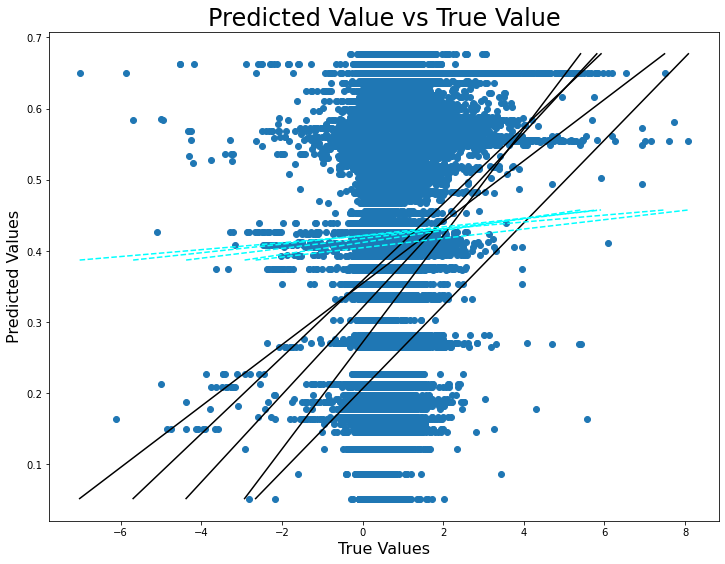

,lassoCV
01 Train score,0.1078
02 Test score,0.1059
03 Train MCRSME,0.7973
04 Test MCRSME,0.7964


In [30]:
lassoCV = MultiOutputRegressor(estimator=LassoCV(alphas = None, cv = 10))
metrics['lassoCV'] = model_metrics('lassoCV', lassoCV)
pd.DataFrame(metrics)

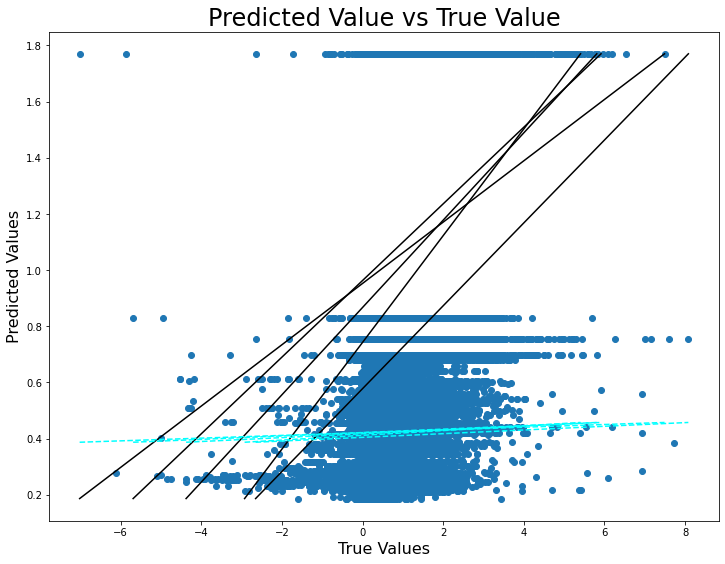

,lassoCV,SVR
01 Train score,0.1078,0.1952
02 Test score,0.1059,0.1914
03 Train MCRSME,0.7973,0.7537
04 Test MCRSME,0.7964,0.7541


In [31]:
svr = MultiOutputRegressor(estimator=SVR(C=1.0, epsilon=0.2))
metrics['SVR'] = model_metrics('svr', svr)
pd.DataFrame(metrics)

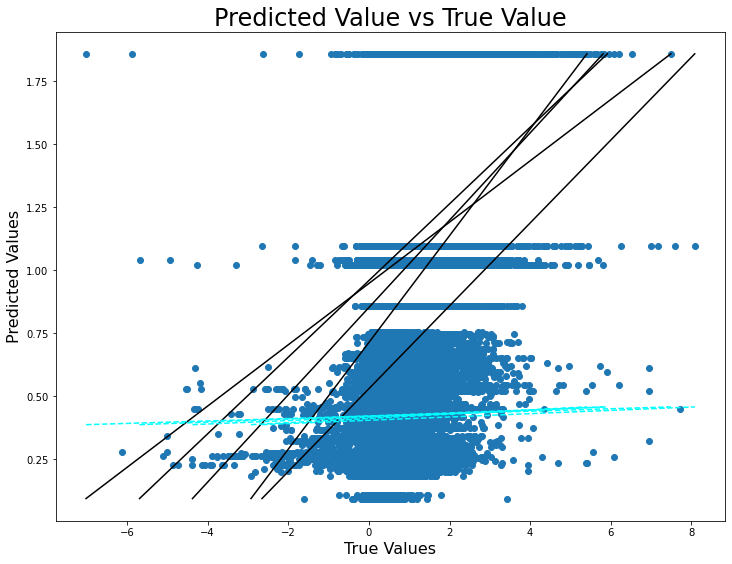

,lassoCV,SVR,xgb_mod
01 Train score,0.1078,0.1952,0.2192
02 Test score,0.1059,0.1914,0.2136
03 Train MCRSME,0.7973,0.7537,0.7428
04 Test MCRSME,0.7964,0.7541,0.7439


In [32]:
xgb_mod = MultiOutputRegressor(estimator=xgb.XGBRegressor(subsample=0.8, colsample_bytree=0.75, reg_lambda=2, reg_alpha=1, random_state=28))
metrics['xgb_mod'] = model_metrics('xgb_mod', xgb_mod)
pd.DataFrame(metrics)

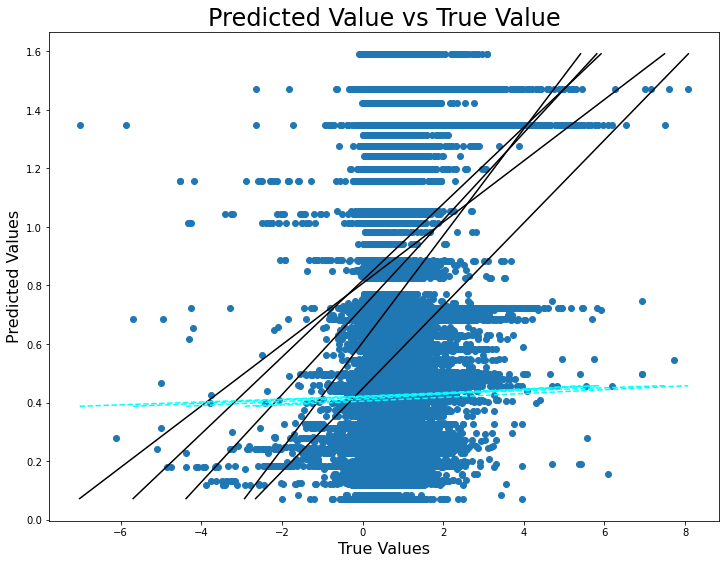

,lassoCV,SVR,xgb_mod,KNN
01 Train score,0.1078,0.1952,0.2192,0.1012
02 Test score,0.1059,0.1914,0.2136,0.0971
03 Train MCRSME,0.7973,0.7537,0.7428,0.7967
04 Test MCRSME,0.7964,0.7541,0.7439,0.7970


In [33]:
knn = MultiOutputRegressor(estimator=KNeighborsRegressor())
metrics['KNN'] = model_metrics('knn', knn)
pd.DataFrame(metrics)

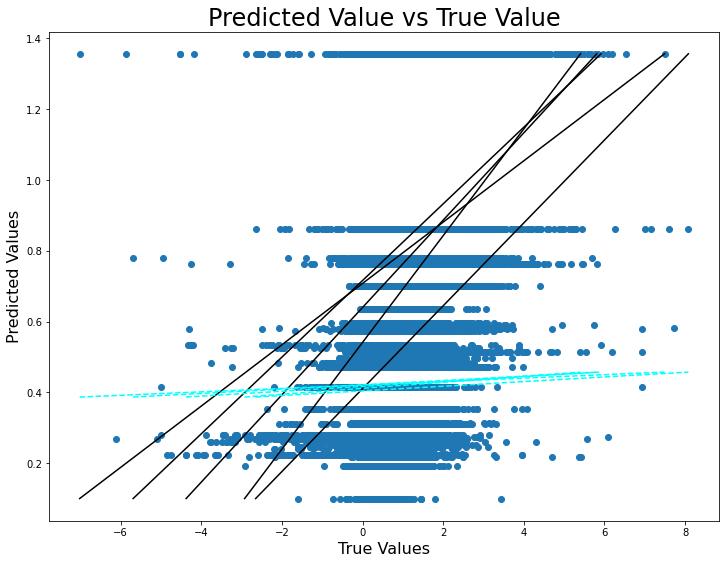

,lassoCV,SVR,xgb_mod,KNN,decision_tree
01 Train score,0.1078,0.1952,0.2192,0.1012,0.1804
02 Test score,0.1059,0.1914,0.2136,0.0971,0.1749
03 Train MCRSME,0.7973,0.7537,0.7428,0.7967,0.7624
04 Test MCRSME,0.7964,0.7541,0.7439,0.7970,0.7634


In [34]:
decision_tree = MultiOutputRegressor(estimator=DecisionTreeRegressor(max_depth=3,random_state=0))
metrics['decision_tree'] = model_metrics('decision_tree', decision_tree)
pd.DataFrame(metrics)

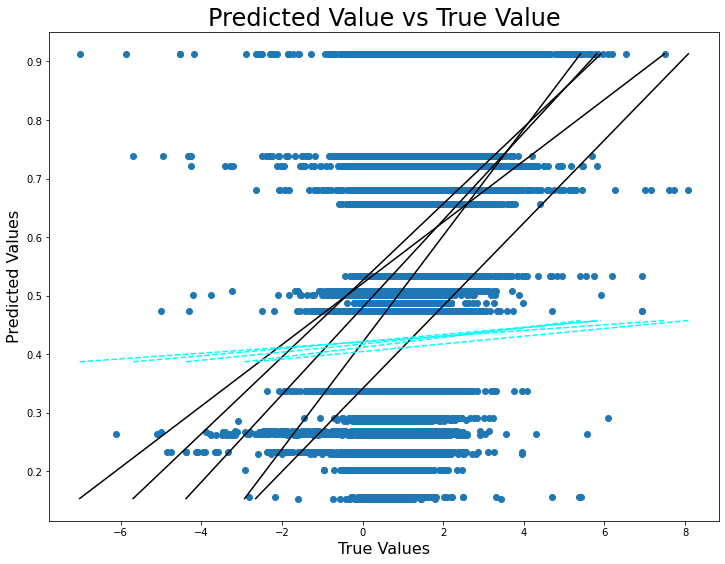

,lassoCV,SVR,xgb_mod,KNN,decision_tree,random_forest
01 Train score,0.1078,0.1952,0.2192,0.1012,0.1804,0.1544
02 Test score,0.1059,0.1914,0.2136,0.0971,0.1749,0.1502
03 Train MCRSME,0.7973,0.7537,0.7428,0.7967,0.7624,0.7757
04 Test MCRSME,0.7964,0.7541,0.7439,0.7970,0.7634,0.7760


In [35]:
random_forest = MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=2, random_state=0))
metrics['random_forest'] = model_metrics('random_forest', random_forest)
pd.DataFrame(metrics)

## Model Evaluation

Regressor model was inspired by refering to the published journal ([reference](https://iopscience.iop.org/article/10.1088/1742-6596/1997/1/012005)). In the published paper, the model of Linear Regression (LR) and Light Gradient Boosting Machine (LGBM) are proposed for models development. However, with fitting the main 3 features of 'sequence', 'structure', 'predicted_loop_type' into 6 different models, none of the model performed well using multioutput regressor. The loss of all 6 models are not closed to 0. Therefore we further evaluate our model using one of the RNN (Recurrent Neural Networks) technique which is Gated Recurrent Unit (GRU) in Part 3 code. 